# NN2: Implementacja propagacji wstecznej błędu
Adrianna Grudzień 


Teoria:\
http://neuralnetworksanddeeplearning.com/chap2.html \
https://towardsdatascience.com/implementing-backpropagation-with-style-in-python-da4c2f49adb4

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import random
import time
import networkx as nx

In [2]:
square_simple_train = pd.read_csv("mio1/regression/square-simple-training.csv", index_col=0)
square_simple_test = pd.read_csv("mio1/regression/square-simple-test.csv", index_col=0)
steps_small_train = pd.read_csv("mio1/regression/steps-small-training.csv", index_col=0)
steps_small_test = pd.read_csv("mio1/regression/steps-small-test.csv", index_col=0)
multimodal_large_train = pd.read_csv("mio1/regression/multimodal-large-training.csv")
multimodal_large_test = pd.read_csv("mio1/regression/multimodal-large-test.csv")

### Pomocnicze funkcje

In [3]:
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

def arrays2tuples(x_array, y_array):
    """
    Tworzy listę krotek (x, y) składających się z poszczególnych obserwacji.
    """
    arr = []
    for i in range(1,len(x_array)):
        arr.append((x_array[i], y_array[i]))
    return arr

def tuples2arrays(tuples_arr):
    """
    Tworzy listę krotek (x, y) składających się z poszczególnych obserwacji.
    """
    x_arr = []
    y_arr = []
    for i in range(len(tuples_arr)):
        x_arr.append(tuples_arr[i][0])
        y_arr.append(tuples_arr[i][1])
    return [x_arr, y_arr]

def normalize_data(data):
    """data (array)"""
    return (data - np.min(data)) / (np.max(data) - np.min(data))

### Definicja sieci
- **sizes**: *array[int]* \
liczba neuronów w kolejnych warstwach

In [17]:
class Network:
    def __init__(self, sizes):
        self.sizes = sizes
        self.num_layers = len(sizes)
  
#         # Xavier method
#         # inicjalizacja wag:
#         weights = []
#         for i in range(1,len(sizes)):
#             # number of nodes in the previous layer
#             n = self.sizes[i-1]
#             weights.append(np.random.uniform(-1/np.sqrt(n),1/np.sqrt(n),[sizes[i], sizes[i-1]]))
#         #inicjalizacja biasów:
#         biases = []
#         for i in range(1, len(sizes)):
#             n = self.sizes[i-1]
#             biases.append(np.random.uniform(-1/np.sqrt(n),1/np.sqrt(n),[sizes[i],1]))
        
#         self.weights = weights
#         self.biases = biases
        
        # wagi z rozkładu normalnego
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]
        
        self.mse = [] # mse


    def feedforward(self, x):
        x = np.matrix(x)
        for b, w in zip(self.biases, self.weights):
            x = sigmoid(np.dot(w, x)+b)
        return x
    
    def update_mini_batch(self, mini_batch, eta):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.back_propagate(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
            
        self.weights = [w-(eta/len(mini_batch))*nw 
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb 
                       for b, nb in zip(self.biases, nabla_b)]
        
        
    def train(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):     
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                mse = metrics.mean_absolute_error(self.feedforward(np.matrix(tuples2arrays(test_data)[0])), np.matrix(tuples2arrays(test_data)[1]))
                self.mse.append(mse)
                
    def back_propagate(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
            
        for i in activations:
            print(i.shape)
        # backward 
        delta = self.cost_derivative(activations[-1], y) * sigmoid_prime(zs[-1])
        print(delta.shape)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
 
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)
    
    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)

### Wizualizacja wartości wag - definicja funkcji
(z użyciem pakietu **networkx**)

In [9]:
def show_weighted_graph(network, weights):
    G=nx.Graph()

    # rysowanie węzłów:
    for layer in range(len(network.sizes)):
        for neuron in range(network.sizes[layer]):
            G.add_node((layer,neuron), pos=(layer, neuron))

    # rysowanie krawędzi:
    for layer in range(len(network.sizes)-2):
    #     print(layer)
        for neuron1 in range(network.sizes[layer]):
            for neuron2 in range(network.sizes[layer+1]):
                if weights[layer].shape[1] == 1:
                    weight = weights[layer][neuron2]
                else:
                    weight = weights[layer][neuron1][neuron2]
                G.add_edge((layer,neuron1), (layer+1,neuron2), weight=np.round(weight,3))

    layer = len(net.sizes)-2 # nr przedostatniej warstwy
    for neuron1 in range(network.sizes[layer+1]):
        for neuron2 in range(network.sizes[layer]):
            if weights[layer].shape[1] == 1:
                weight = weights[layer][neuron2]
            else:
                weight = weights[layer][neuron1][neuron2]
            G.add_edge((layer+1,neuron1), (layer,neuron2), weight=np.round(weight,3))

    labels = nx.get_edge_attributes(G,'weight')
    pos = (nx.get_node_attributes(G, 'pos'))
    nx.draw(G, pos)

    edge_labels = nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

In [10]:
                mse = metrics.mean_absolute_error(self.feedforward(np.matrix(tuples2arrays(test_data)[0])), np.matrix(tuples2arrays(test_data)[1]))


NameError: name 'self' is not defined

## Zbiór `square-simple`

In [7]:
x = square_simple_train['x']
y = normalize_data(square_simple_train['y'])

x_test = square_simple_test['x']
y_test = normalize_data(square_simple_test['y'])

Wagi sprzed treningu:

In [6]:
net = Network([1,5,5,1])
show_weighted_graph(net, net.weights)
print('MSE: ', metrics.mean_absolute_error(net.feedforward(x), np.matrix(y)))

NameError: name 'show_weighted_graph' is not defined

Trening i wagi po treningu:

In [20]:
start = time.time()
net.train(arrays2tuples(x,y), np.int(1e5), 2, 1e-3, arrays2tuples(x_test,y_test))
end = time.time()
print('training time: ', end - start, 's')
show_weighted_graph(net, net.weights)
print('MSE: ', metrics.mean_absolute_error(net.feedforward(x), np.matrix(y)))

<ipython-input-20-7c6df9f16182>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  net.train(arrays2tuples(x,y), np.int(1e5), 2, 1e-3, arrays2tuples(x_test,y_test))


()
(3, 1)
(2, 1)
(1, 1)
(1, 1)
()
(3, 1)
(2, 1)
(1, 1)
(1, 1)
()
(3, 1)
(2, 1)
(1, 1)
(1, 1)
()
(3, 1)
(2, 1)
(1, 1)
(1, 1)
()
(3, 1)
(2, 1)
(1, 1)
(1, 1)
()
(3, 1)
(2, 1)
(1, 1)
(1, 1)
()
(3, 1)
(2, 1)
(1, 1)
(1, 1)
()
(3, 1)
(2, 1)
(1, 1)
(1, 1)
()
(3, 1)
(2, 1)
(1, 1)
(1, 1)
()
(3, 1)
(2, 1)
(1, 1)
(1, 1)
()
(3, 1)
(2, 1)
(1, 1)
(1, 1)
()
(3, 1)
(2, 1)
(1, 1)
(1, 1)
()
(3, 1)
(2, 1)
(1, 1)
(1, 1)
()
(3, 1)
(2, 1)
(1, 1)
(1, 1)
()
(3, 1)
(2, 1)
(1, 1)
(1, 1)
()
(3, 1)
(2, 1)
(1, 1)
(1, 1)
()
(3, 1)
(2, 1)
(1, 1)
(1, 1)
()
(3, 1)
(2, 1)
(1, 1)
(1, 1)
()
(3, 1)
(2, 1)
(1, 1)
(1, 1)
()
(3, 1)
(2, 1)
(1, 1)
(1, 1)
()
(3, 1)
(2, 1)
(1, 1)
(1, 1)
()
(3, 1)
(2, 1)
(1, 1)
(1, 1)
()
(3, 1)
(2, 1)
(1, 1)
(1, 1)
()
(3, 1)
(2, 1)
(1, 1)
(1, 1)
()
(3, 1)
(2, 1)
(1, 1)
(1, 1)
()
(3, 1)
(2, 1)
(1, 1)
(1, 1)
()
(3, 1)
(2, 1)
(1, 1)
(1, 1)
()
(3, 1)
(2, 1)
(1, 1)
(1, 1)
()
(3, 1)
(2, 1)
(1, 1)
(1, 1)
()
(3, 1)
(2, 1)
(1, 1)
(1, 1)
()
(3, 1)
(2, 1)
(1, 1)
(1, 1)
()
(3, 1)
(2, 1)
(1, 1)
(1, 1)
()
(3, 1

KeyboardInterrupt: 

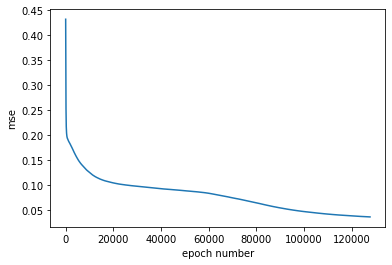

In [11]:
plt.plot(np.arange(len(net.mse)), net.mse)
plt.ylabel("mse")
plt.xlabel("epoch number")
plt.show()

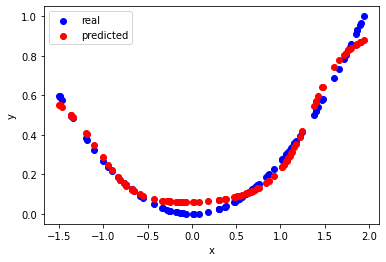

In [12]:
y_pred = net.feedforward(np.matrix(x))

plt.scatter(x,y, color='blue')
plt.scatter(x,np.array(y_pred.flatten()), color='red')
plt.legend(['real', 'predicted'])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Zbiór `steps-small`

In [13]:
x = steps_small_train['x']
y = normalize_data(steps_small_train['y'])

x_test = steps_small_test['x']
y_test = normalize_data(steps_small_test['y'])

Wagi sprzed treningu:

MSE:  0.3719937765921307


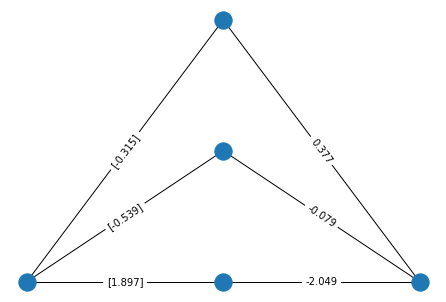

In [14]:
net = Network([1,3,1])
show_weighted_graph(net, net.weights)
print('MSE: ', metrics.mean_absolute_error(net.feedforward(x), np.matrix(y)))

Trening i wagi po treningu:

training time:  374.45302844047546 s
MSE:  0.09202001834315178


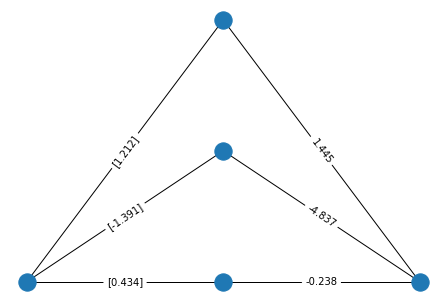

In [15]:
start = time.time()
net.train(arrays2tuples(x,y), np.int(1e5), 2, 1e-3, arrays2tuples(x_test,y_test))
end = time.time()
print('training time: ', end - start, 's')
show_weighted_graph(net, net.weights)
print('MSE: ', metrics.mean_absolute_error(net.feedforward(x), np.matrix(y)))

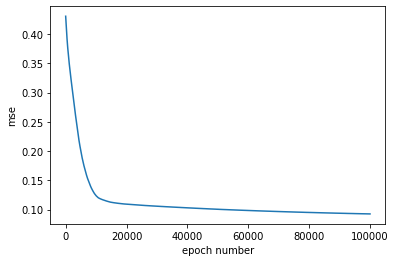

In [16]:
plt.plot(np.arange(len(net.mse)), net.mse)
plt.ylabel("mse")
plt.xlabel("epoch number")
plt.show()

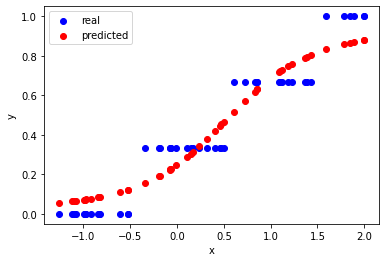

In [17]:
y_pred = net.feedforward(np.matrix(x))

plt.scatter(x,y, color='blue')
plt.scatter(x,np.array(y_pred.flatten()), color='red')
plt.legend(['real', 'predicted'])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Zbiór `multimodal-large`

In [18]:
x = multimodal_large_train['x']
y = normalize_data(multimodal_large_train['y'])

x_test = multimodal_large_test['x']
y_test = normalize_data(multimodal_large_test['y'])

Wagi sprzed treningu:

MSE:  0.39450062396440716


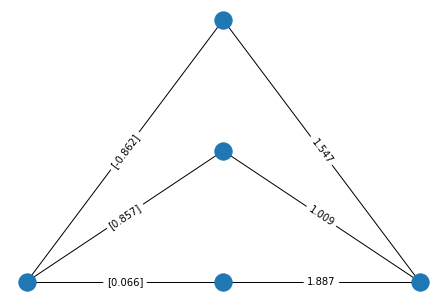

In [19]:
net = Network([1,3,1])
show_weighted_graph(net, net.weights)
print('MSE: ', metrics.mean_absolute_error(net.feedforward(x), np.matrix(y)))

Trening i wagi po treningu:

training time:  496.2127740383148 s
MSE:  0.11010380653463363


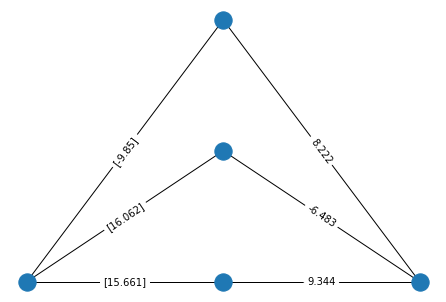

In [21]:
start = time.time()
net.train(arrays2tuples(x,y), np.int(1e3), 2, 1e-3, arrays2tuples(x_test,y_test))
end = time.time()
print('training time: ', end - start, 's')
show_weighted_graph(net, net.weights)
print('MSE: ', metrics.mean_absolute_error(net.feedforward(x), np.matrix(y)))

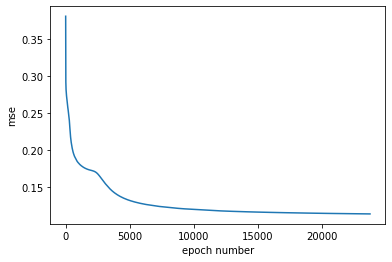

In [22]:
plt.plot(np.arange(len(net.mse)), net.mse)
plt.ylabel("mse")
plt.xlabel("epoch number")
plt.show()

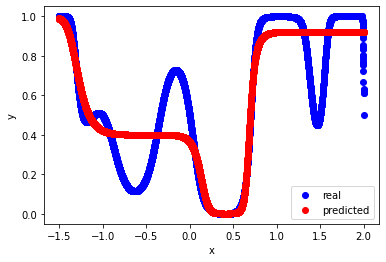

In [23]:
y_pred = net.feedforward(np.matrix(x))

plt.scatter(x,y, color='blue')
plt.scatter(x,np.array(y_pred.flatten()), color='red')
plt.legend(['real', 'predicted'])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [9]:
class Network2(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]
        self.mse = []

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def train(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                mse = metrics.mean_absolute_error(self.feedforward(np.matrix(tuples2arrays(test_data)[0])), np.matrix(tuples2arrays(test_data)[1]))
                self.mse.append(mse)
            else:
                print("Epoch {0} complete".format(j))

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)

In [42]:
class Network3:
    def __init__(self, structure):
        self.structure = structure
        self.num_layers = len(structure) 
        self.Bₙ = [np.random.randn(l, 1) for l in structure[1:]] 
        
        self.Wₙ = [np.random.randn(l, next_l) for l, next_l in zip(structure[:-1], structure[1:])]
        
    def backprop(self, x, y):        
        მJⳆმBₙₛ = [np.zeros(b.shape) for b in self.Bₙ]
        მJⳆმWₙₛ = [np.zeros(W.shape) for W in self.Wₙ]

        Zₙ = [] 
        Aₙ = [] 
        for b, W in zip(self.Bₙ, self.Wₙ):
            z = W.T @ a + b if Zₙ else W.T @ x + b
            a = σ(z)
            Zₙ.append(z)
            Aₙ.append(a)
        
        H = self.num_layers-2
        for L in range(H, -1, -1):
            δ =  σࠤ(Zₙ[L]) * (self.Wₙ[L+1] @ δ) if L != H else ᐁC(Aₙ[L], y) * σࠤ(Zₙ[L])
            მJⳆმBₙₛ[L] = δ
            მJⳆმWₙₛ[L] = Aₙ[L-1] @ δ.T if L != 0 else x @ δ.T
        
        return (მJⳆმBₙₛ, მJⳆმWₙₛ)
    
    def gradient_descent(self, mini_batch, λ):
        მJⳆმBₙ= [np.zeros(b.shape) for b in self.Bₙ]
        მJⳆმWₙ = [np.zeros(W.shape) for W in self.Wₙ]

        for x, y in mini_batch:
            მJⳆმBₙₛ, მJⳆმWₙₛ = self.backprop(x, y)
            მJⳆმBₙ = [მJⳆმb + მJⳆმbₛ for მJⳆმb, მJⳆმbₛ in zip(მJⳆმBₙ, მJⳆმBₙₛ)]  
            მJⳆმWₙ = [მJⳆმW + მJⳆმWₛ for მJⳆმW, მJⳆმWₛ in zip(მJⳆმWₙ, მJⳆმWₙₛ)]

        d = len(mini_batch)
        self.Wₙ = [W - λ/d * მJⳆმW for W, მJⳆმW in zip(self.Wₙ, მJⳆმWₙ)]
        self.Bₙ = [b - λ/d * მJⳆმb for b, მJⳆმb in zip(self.Bₙ, მJⳆმBₙ)]
            
    def train(self, epochs, training_data, λ):
        for j in range(epochs):
            for mini_batch in training_data:
                self.gradient_descent(mini_batch, λ)       
                


def ᐁC(aᴺ, y):    
    return (aᴺ-y)                 #so we can easily change the cost.


def σ(z):
    return 1.0/(1.0+np.exp(-z))


def σࠤ(z):
    return σ(z)*(1-σ(z))


my_net = Network3([3, 2 ,2])
print("Initial Weights:")
print(my_net.Wₙ[0])
#the following generates a list of cnt vectors of length dim.
random_vectors = lambda dim, cnt: [np.random.rand(dim, 1) for i in range(cnt)]
random_batch= list(zip(random_vectors(3, 64) , random_vectors(2, 64)))
my_net.gradient_descent(random_batch, 3.0)
print("Optimized Weights:")
print(my_net.Wₙ[0])

Initial Weights:
[[ 0.65146157  1.07453532]
 [-0.44030267  0.20285185]
 [ 0.2949501   0.84645291]]
Optimized Weights:
[[ 0.65222843  1.04749232]
 [-0.43833841  0.1811858 ]
 [ 0.29686234  0.82331366]]
